In [ ]:
# Lightweight SNR–SER comparison (load UNet, train CAE/DnCNN)
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


2025-10-14 14:53:45.555563: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-14 14:53:45.587699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-14 14:53:45.587726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-14 14:53:45.588936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-14 14:53:45.594684: I tensorflow/core/platform/cpu_feature_guar

TensorFlow: 2.15.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-10-14 14:53:47.134962: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-14 14:53:47.229630: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-14 14:53:47.229686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# Data: CIFAR-10 and z-score helpers
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')/255.0; y_train = y_train.flatten()
x_test  = x_test.astype('float32')/255.0;  y_test  = y_test.flatten()

MEAN = tf.constant(np.mean(x_train, axis=(0,1,2)), dtype=tf.float32)
STD  = tf.constant(np.std(x_train,  axis=(0,1,2)) + 1e-6, dtype=tf.float32)

def to_zscore(x):
    return (x - MEAN) / STD

def from_zscore(z):
    return z * STD + MEAN

cifar10_class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print('Data ready:', x_train.shape, x_test.shape)


2025-10-14 14:53:48.283581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-14 14:53:48.283656: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-14 14:53:48.283671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-14 14:53:48.423445: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-14 14:53:48.423531: I external/local_xla/xla/stream_executor

Data ready: (50000, 32, 32, 3) (10000, 32, 32, 3)


In [3]:
# Noise: fixed SNR generators (Gaussian/S&P/Burst)

def gaussian_snr_to_cond_vector(snr_db) -> tf.Tensor:
    # Fully TF-native: accept tensor or float
    snr_db = tf.cast(snr_db, tf.float32)
    log10_sigma = -snr_db / 20.0
    c = tf.clip_by_value(log10_sigma - 0.5, 0.0, 1.0)
    return tf.stack([tf.constant(1.0), tf.constant(0.0), tf.constant(0.0), c])


def add_gaussian_noise_fixed_snr(clean_img_01: tf.Tensor, snr_db):
    img_z = to_zscore(clean_img_01)
    snr_db = tf.cast(snr_db, tf.float32)
    sigma = tf.pow(10.0, -snr_db/20.0)
    noise = tf.random.normal(tf.shape(img_z), stddev=sigma, dtype=tf.float32)
    noisy_z = img_z + noise
    cond = gaussian_snr_to_cond_vector(snr_db)
    return noisy_z, cond


def snr_scale_noise(clean_z: tf.Tensor, noisy_z: tf.Tensor, target_snr_db: tf.Tensor):
    noise = noisy_z - clean_z
    px = tf.reduce_mean(tf.square(clean_z))
    pn = tf.reduce_mean(tf.square(noise)) + 1e-12
    r = tf.pow(10.0, target_snr_db/10.0)
    pn_target = px / r
    k = tf.sqrt(tf.maximum(pn_target / pn, 1e-12))
    return clean_z + k*noise


def add_sp_noise_fixed_snr(clean_img_01: tf.Tensor, snr_db: tf.Tensor, amount: float = 0.15):
    img_z = to_zscore(clean_img_01)
    u = tf.random.uniform(tf.shape(img_z))
    salt = tf.cast(u < amount*0.5, tf.float32)
    pepper = tf.cast(u > 1.0 - amount*0.5, tf.float32)
    noisy_z = img_z * (1.0 - salt - pepper) + salt
    noisy_z = snr_scale_noise(img_z, noisy_z, snr_db)
    return noisy_z, tf.convert_to_tensor([0.0,1.0,0.0,amount], dtype=tf.float32)


def add_burst_noise_fixed_snr(clean_img_01: tf.Tensor, snr_db: tf.Tensor, size_factor: float = 0.3, intensity: float = 0.85):
    img_z = to_zscore(clean_img_01)
    h = tf.shape(img_z)[0]; w = tf.shape(img_z)[1]; cch = tf.shape(img_z)[2]
    bh = tf.maximum(1, tf.cast(tf.cast(h, tf.float32)*size_factor, tf.int32))
    bw = tf.maximum(1, tf.cast(tf.cast(w, tf.float32)*size_factor, tf.int32))
    sy = tf.random.uniform([], maxval=tf.maximum(1, h-bh), dtype=tf.int32)
    sx = tf.random.uniform([], maxval=tf.maximum(1, w-bw), dtype=tf.int32)
    patch = tf.random.normal([bh, bw, cch], stddev=intensity)
    noise = tf.pad(patch, [[sy, h-sy-bh], [sx, w-sx-bw], [0,0]])
    mask  = tf.pad(tf.ones([bh, bw, cch]), [[sy, h-sy-bh], [sx, w-sx-bw], [0,0]])
    noisy_z = img_z * (1.0 - mask) + (img_z + noise) * mask
    noisy_z = snr_scale_noise(img_z, noisy_z, snr_db)
    c = tf.clip_by_value(size_factor*intensity, 0.0, 1.0)
    return noisy_z, tf.convert_to_tensor([0.0,0.0,1.0,c], dtype=tf.float32)


def make_fixed_snr_dataset_noise(x, y, snr_db: float, noise_type: str = 'gaussian', batch_size: int = 128):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    def _map_fn(clean_img, label):
        clean_img = tf.cast(clean_img, tf.float32)
        sdb = tf.cast(snr_db, tf.float32)
        if noise_type == 'gaussian': noisy_z, cond = add_gaussian_noise_fixed_snr(clean_img, sdb)
        elif noise_type in ('sp','s&p'): noisy_z, cond = add_sp_noise_fixed_snr(clean_img, sdb)
        elif noise_type == 'burst': noisy_z, cond = add_burst_noise_fixed_snr(clean_img, sdb)
        else: raise ValueError(noise_type)
        clean_z = to_zscore(clean_img)
        return (noisy_z, cond), (clean_z, label)
    return ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [4]:
# Load pretrained UNet (conditional multitask UNet)
unet_path = 'best_cifar10_conditional_model.keras'
unet_model = tf.keras.models.load_model(unet_path)
print('Loaded UNet from:', unet_path)
print('UNet inputs:', [inp.name for inp in unet_model.inputs])


Loaded UNet from: best_cifar10_conditional_model.keras
UNet inputs: ['image_input', 'noise_map_input']


In [ ]:
# CAE/DnCNN multitask models

def build_cae_multitask(input_shape_img=(32,32,3), input_shape_map=(4,), num_classes=10):
    img_in  = layers.Input(shape=input_shape_img, name='image_input')
    cond_in = layers.Input(shape=input_shape_map, name='noise_map_input')
    x = layers.Conv2D(32,3,padding='same',activation='relu')(img_in)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(x)
    s1 = x  # 32x32
    p1 = layers.MaxPooling2D(2)(s1)  # 16x16
    x = layers.Conv2D(64,3,padding='same',activation='relu')(p1)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    s2 = x  # 16x16
    p2 = layers.MaxPooling2D(2)(s2)  # 8x8
    x = layers.Conv2D(128,3,padding='same',activation='relu')(p2)
    x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
    feat = layers.GlobalAveragePooling2D()(x)
    feat = layers.Concatenate()([feat, cond_in])
    feat = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(feat)
    feat = layers.Dropout(0.5)(feat)
    cls_out = layers.Dense(num_classes, activation='softmax', name='classification_output')(feat)
    d = layers.Conv2DTranspose(64,2,strides=2,padding='same')(x)  # 16x16
    d = layers.Concatenate()([d, s2])
    d = layers.Conv2D(64,3,padding='same',activation='relu')(d)
    d = layers.Conv2D(64,3,padding='same',activation='relu')(d)
    d = layers.Conv2DTranspose(32,2,strides=2,padding='same')(d)  # 32x32
    d = layers.Concatenate()([d, s1])
    d = layers.Conv2D(32,3,padding='same',activation='relu')(d)
    d = layers.Conv2D(32,3,padding='same',activation='relu')(d)
    rec = layers.Conv2D(3,1,activation='linear', name='restoration_output')(d)
    return Model(inputs=[img_in, cond_in], outputs=[rec, cls_out], name='CAE_multitask')


def build_dncnn_multitask(input_shape_img=(32,32,3), input_shape_map=(4,), num_classes=10, depth=17, filters=64):
    img_in  = layers.Input(shape=input_shape_img, name='image_input')
    cond_in = layers.Input(shape=input_shape_map, name='noise_map_input')
    x = layers.Conv2D(filters,3,padding='same',activation='relu')(img_in)
    for _ in range(depth-2):
        x = layers.Conv2D(filters,3,padding='same',use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    res = layers.Conv2D(3,3,padding='same',activation='linear', name='residual_pred')(x)
    rec = layers.Subtract(name='restoration_output')([img_in, res])
    feat = layers.GlobalAveragePooling2D()(x)
    feat = layers.Concatenate()([feat, cond_in])
    feat = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(feat)
    feat = layers.Dropout(0.5)(feat)
    cls_out = layers.Dense(num_classes, activation='softmax', name='classification_output')(feat)
    return Model(inputs=[img_in, cond_in], outputs=[rec, cls_out], name='DnCNN_multitask')

# Learning rate schedule (match UNet): ExponentialDecay per-step
STEPS_PER_EPOCH = int(np.ceil(len(x_train)/128))
initial_learning_rate = 1e-4
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=STEPS_PER_EPOCH,
    decay_rate=0.96,
    staircase=True
)

cae_model = build_cae_multitask(num_classes=10)
dncnn_model = build_dncnn_multitask(num_classes=10)

for m in [cae_model, dncnn_model]:
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss={'restoration_output':'mae','classification_output':'sparse_categorical_crossentropy'},
              loss_weights={'restoration_output':0.8,'classification_output':0.2},
              metrics={'classification_output':'accuracy'})

print('CAE/DnCNN ready with LR schedule')



CAE/DnCNN ready with LR schedule


In [6]:
# Mixed-SNR training dataset (Gaussian only by default)
BATCH_SIZE = 128

def gen_mixed_gaussian_sample(clean_img, label):
    clean_img = tf.cast(clean_img, tf.float32)
    snr_db = tf.random.uniform([], -30.0, -10.0)
    noisy_z, cond = add_gaussian_noise_fixed_snr(clean_img, snr_db)
    clean_z = to_zscore(clean_img)
    return (noisy_z, cond), (clean_z, label)

train_ds_mixed = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                  .shuffle(50000)
                  .map(gen_mixed_gaussian_sample, num_parallel_calls=tf.data.AUTOTUNE)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.AUTOTUNE))

val_ds_mixed = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                .map(gen_mixed_gaussian_sample, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

print('Datasets ready')


Datasets ready


In [ ]:
# Mixed-noise training dataset (Gaussian + S&P + Burst)
BATCH_SIZE = 128

def gen_mixed_noise_sample(clean_img, label):
    clean_img = tf.cast(clean_img, tf.float32)
    snr_db = tf.random.uniform([], -30.0, -10.0)
    choice = tf.random.uniform([], 0, 3, dtype=tf.int32)

    def _gauss():
        return add_gaussian_noise_fixed_snr(clean_img, snr_db)

    def _sp():
        amount = tf.random.uniform([], 0.05, 0.25)
        return add_sp_noise_fixed_snr(clean_img, snr_db, amount=amount)

    def _burst():
        size_factor = tf.random.uniform([], 0.15, 0.40)
        intensity   = tf.random.uniform([], 0.60, 1.00)
        return add_burst_noise_fixed_snr(clean_img, snr_db, size_factor=size_factor, intensity=intensity)

    noisy_z, cond = tf.switch_case(choice, branch_fns={
        0: _gauss,
        1: _sp,
        2: _burst,
    })
    clean_z = to_zscore(clean_img)
    return (noisy_z, cond), (clean_z, label)

train_ds_mixed_types = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                        .shuffle(50000)
                        .map(gen_mixed_noise_sample, num_parallel_calls=tf.data.AUTOTUNE)
                        .batch(BATCH_SIZE)
                        .prefetch(tf.data.AUTOTUNE))

val_ds_mixed_types = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                      .map(gen_mixed_noise_sample, num_parallel_calls=tf.data.AUTOTUNE)
                      .batch(BATCH_SIZE)
                      .prefetch(tf.data.AUTOTUNE))

print('Mixed-noise datasets ready (Gaussian/S&P/Burst)')


In [ ]:
# Baseline UNet (no conditioning) setup: datasets + model + compile
from models import build_unet_multitask

# Unconditioned datasets: model takes only noisy image z-scores as input
BATCH_SIZE = 128

def drop_cond_for_uncond(inp, tgt):
    noisy_z, cond = inp
    clean_z, label = tgt
    return noisy_z, (clean_z, label)

train_ds_mixed_uncond = train_ds_mixed.map(drop_cond_for_uncond)
val_ds_mixed_uncond   = val_ds_mixed.map(drop_cond_for_uncond)

# Build and compile baseline UNet (multitask: restoration + classification)
unet_base = build_unet_multitask(input_shape_img=(32,32,3), num_classes=10, residual=True)
unet_base.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss={'restoration_output':'mae','classification_output':'sparse_categorical_crossentropy'},
    loss_weights={'restoration_output':0.8,'classification_output':0.2},
    metrics={'classification_output':'accuracy'}
)

unet_base_ckpt = 'best_unet_baseline.keras'
callbacks_unet_base = [
    EarlyStopping(monitor='val_classification_output_accuracy', patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath=unet_base_ckpt, save_weights_only=False, monitor='val_classification_output_accuracy', mode='max', save_best_only=True)
]

if os.path.exists(unet_base_ckpt):
    print(f'Loading baseline UNet from {unet_base_ckpt}')
    unet_base = tf.keras.models.load_model(unet_base_ckpt)
else:
    print('\nTraining baseline UNet (up to 200 epochs, early-stop) ...')
    unet_base.fit(train_ds_mixed_uncond, epochs=EPOCHS, validation_data=val_ds_mixed_uncond, callbacks=callbacks_unet_base, verbose=1)
    print('Saved best baseline UNet to', unet_base_ckpt)


In [ ]:
# SER evaluator for baseline UNet (single input)

def eval_unet_base_ser_over_snrs(model, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    results = {}
    for snr in snr_list_db:
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        total = 0; errors = 0
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            rec_b, logits_b = model.predict(noisy_z_b, verbose=0)
            pred = np.argmax(logits_b, axis=-1)
            total += label_b.shape[0]
            errors += int(np.sum(pred != label_b.numpy()))
        results[float(snr)] = errors / max(1, total)
    return results


In [ ]:
# Evaluate and plot: UNet (MTL) vs Baseline UNet (no cond)
try:
    unet_base_ser = eval_unet_base_ser_over_snrs(unet_base, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
    compare_map = {
        'UNet (MTL)': unet_ser,
        'UNet (Base)': unet_base_ser,
    }
    plot_snr_ser(compare_map, title='Gaussian: SNR vs SER (UNet MTL vs UNet Base)')
except Exception as e:
    print('Baseline UNet evaluation skipped due to error:', e)


In [7]:
# SER evaluators and plotting

def eval_model_ser_over_snrs(model, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    results = {}
    for snr in snr_list_db:
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        total = 0; errors = 0
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            _, logits_b = model.predict([noisy_z_b, cond_b], verbose=0)
            pred = np.argmax(logits_b, axis=-1)
            total += label_b.shape[0]
            errors += int(np.sum(pred != label_b.numpy()))
        results[float(snr)] = errors / max(1, total)
    return results


def plot_snr_ser(models_ser_dict, title='SNR vs SER', threshold=0.10):
    plt.figure(figsize=(7,5))
    for name, ser_map in models_ser_dict.items():
        snrs = np.array(sorted(ser_map.keys()))
        sers = np.array([ser_map[s] for s in snrs])
        plt.plot(snrs, sers, marker='o', label=name)
        idx = np.where(np.diff((sers <= threshold).astype(int)) != 0)[0]
        if idx.size > 0:
            i = idx[0]
            x0,x1 = snrs[i], snrs[i+1]; y0,y1 = sers[i], sers[i+1]
            if y1 != y0:
                x_cross = x0 + (threshold - y0) * (x1 - x0) / (y1 - y0)
                plt.scatter([x_cross],[threshold], marker='x', s=80)
                plt.text(x_cross, threshold+0.02, f"{name}: {x_cross:.1f} dB", ha='center', fontsize=9)
    plt.axhline(threshold, color='gray', ls='--', lw=1, label='SER=0.10')
    plt.ylim(0,1); plt.xlabel('SNR (dB)'); plt.ylabel('SER'); plt.title(title); plt.grid(ls=':'); plt.legend(); plt.show()


In [8]:
# Evaluate UNet SER first (Gaussian)
snr_grid = list(range(-30, -9, 2))
unet_ser = eval_model_ser_over_snrs(unet_model, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
print('UNet SER computed for', len(snr_grid), 'SNR points')


2025-10-14 14:53:55.254326: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905


UNet SER computed for 11 SNR points


Loading CAE weights from best_cae_multitask.keras


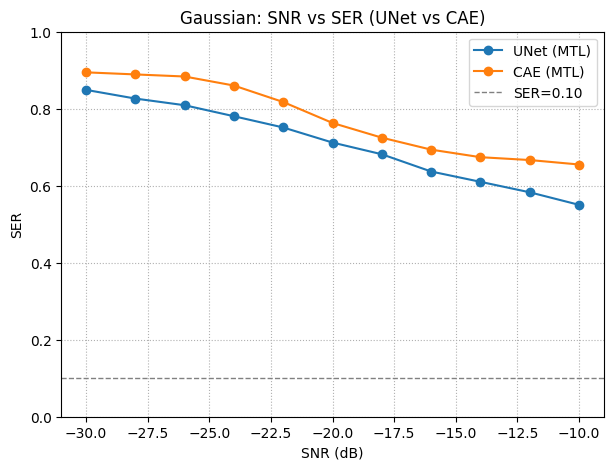

In [9]:
# Train/Load CAE MTL only, then evaluate SER (Gaussian)
EPOCHS = 200
cae_ckpt = 'best_cae_multitask.keras'


callbacks_cae = [
    EarlyStopping(monitor='val_classification_output_accuracy', patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath=cae_ckpt, save_weights_only=False, monitor='val_classification_output_accuracy', mode='max', save_best_only=True)
]

if os.path.exists(cae_ckpt):
    print(f'Loading CAE weights from {cae_ckpt}')
    cae_model = tf.keras.models.load_model(cae_ckpt)
else:
    print('\nTraining CAE (up to 200 epochs, early-stop) ...')
    cae_model.fit(train_ds_mixed, epochs=EPOCHS, validation_data=val_ds_mixed, callbacks=callbacks_cae, verbose=1)

cae_ser = eval_model_ser_over_snrs(cae_model, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)

models_map = {'UNet (MTL)': unet_ser, 'CAE (MTL)': cae_ser}
plot_snr_ser(models_map, title='Gaussian: SNR vs SER (UNet vs CAE)')

In [11]:
# Fixed classifier (clean CIFAR-10) with load-if-exists

def build_fixed_classifier(input_shape=(32,32,3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs, name='FixedClassifier')

clf_ckpt = 'best_fixed_classifier.keras'
if os.path.exists(clf_ckpt):
    print(f'Loading fixed classifier from {clf_ckpt}')
    fixed_clf = tf.keras.models.load_model(clf_ckpt)
else:
    fixed_clf = build_fixed_classifier()
    fixed_clf.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    clf_callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
        ModelCheckpoint(filepath=clf_ckpt, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
    ]
    print('\nTraining fixed classifier on clean CIFAR-10 ...')
    fixed_clf.fit(x_train, y_train, validation_data=(x_test, y_test),
                  epochs=50, batch_size=256, callbacks=clf_callbacks, verbose=1)
    print('Saved best fixed classifier to', clf_ckpt)




Training fixed classifier on clean CIFAR-10 ...
Epoch 1/50


2025-10-14 15:03:35.137400: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3206111960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-14 15:03:35.137431: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-10-14 15:03:35.150450: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760421815.240732   94320 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 [==============================] - 5s 13ms/step - loss: 1.9920 - accuracy: 0.2378 - val_loss: 1.8567 - val_accuracy: 0.2837
Epoch 2/50
196/196 [==============================] - 2s 9ms/step - loss: 1.7100 - accuracy: 0.3502 - val_loss: 1.6173 - val_accuracy: 0.3915
Epoch 3/50
196/196 [==============================] - 2s 9ms/step - loss: 1.5727 - accuracy: 0.4090 - val_loss: 1.5248 - val_accuracy: 0.4301
Epoch 4/50
196/196 [==============================] - 2s 9ms/step - loss: 1.4872 - accuracy: 0.4495 - val_loss: 1.4321 - val_accuracy: 0.4620
Epoch 5/50
196/196 [==============================] - 2s 9ms/step - loss: 1.4149 - accuracy: 0.4832 - val_loss: 1.3798 - val_accuracy: 0.4949
Epoch 6/50
196/196 [==============================] - 2s 9ms/step - loss: 1.3575 - accuracy: 0.5034 - val_loss: 1.2944 - val_accuracy: 0.5276
Epoch 7/50
196/196 [==============================] - 2s 9ms/step - loss: 1.3115 - accuracy: 0.5211 - val_loss: 1.2545 - val_accuracy: 0.5436
Epoch 8/50
196/1

In [ ]:
# Add UNet restoration-only model into pipeline comparison
from models import build_unet_restoration

unet_rest_ckpt = 'best_unet_restoration.keras'
unet_rest = build_unet_restoration(input_shape=(32,32,3), base_filters=32, depth=3, residual=True)
unet_rest.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mae')

if os.path.exists(unet_rest_ckpt):
    print(f'Loading UNet restoration from {unet_rest_ckpt}')
    unet_rest = tf.keras.models.load_model(unet_rest_ckpt)
else:
    print('\nTraining UNet restoration ...')
    unet_rest.fit(rest_train, validation_data=rest_val, epochs=100,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                             ModelCheckpoint(filepath=unet_rest_ckpt, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)],
                  verbose=1)



In [ ]:
# Evaluate pipeline again with UNet restoration
unet_pipe_ser = eval_pipeline_ser_over_snrs(fixed_clf, unet_rest, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)

models_map = { 'UNet (MTL)': unet_ser }
if 'cae_ser' in globals(): models_map['CAE (MTL)'] = cae_ser
if 'dncnn_ser' in globals(): models_map['DnCNN (MTL)'] = dncnn_ser
models_map.update({
    'No-Rest + FixedClf': no_rest_ser,
    'CAE-Rest + FixedClf': cae_pipe_ser,
    'DnCNN-Rest + FixedClf': dn_pipe_ser,
    'UNet-Rest + FixedClf': unet_pipe_ser,
})
plot_snr_ser(models_map, title='Gaussian: SNR vs SER (MTL vs Pipelines incl. UNet Rest)')


In [12]:
# Basic restoration-only CAE/DnCNN (no conditioning, no classifier head)

def build_cae_restoration(input_shape=(32,32,3)):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(inp)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(x)
    s1 = x
    p1 = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(p1)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    s2 = x
    p2 = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128,3,padding='same',activation='relu')(p2)
    x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
    d = layers.Conv2DTranspose(64,2,strides=2,padding='same')(x)
    d = layers.Concatenate()([d, s2])
    d = layers.Conv2D(64,3,padding='same',activation='relu')(d)
    d = layers.Conv2D(64,3,padding='same',activation='relu')(d)
    d = layers.Conv2DTranspose(32,2,strides=2,padding='same')(d)
    d = layers.Concatenate()([d, s1])
    d = layers.Conv2D(32,3,padding='same',activation='relu')(d)
    d = layers.Conv2D(32,3,padding='same',activation='relu')(d)
    out = layers.Conv2D(3,1,activation='linear')(d)
    return Model(inp, out, name='CAE_restoration')


def build_dncnn_restoration(input_shape=(32,32,3), depth=17, filters=64):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters,3,padding='same',activation='relu')(inp)
    for _ in range(depth-2):
        x = layers.Conv2D(filters,3,padding='same',use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    res = layers.Conv2D(3,3,padding='same',activation='linear')(x)
    out = layers.Subtract()([inp, res])
    return Model(inp, out, name='DnCNN_restoration')

cae_rest_ckpt = 'best_cae_restoration.keras'
dncnn_rest_ckpt = 'best_dncnn_restoration.keras'

cae_rest = build_cae_restoration(); dncnn_rest = build_dncnn_restoration()
for m in [cae_rest, dncnn_rest]:
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mae')

# Train or load restoration-only models using mixed Gaussian SNR data
rest_train = train_ds_mixed.map(lambda inp, tgt: (from_zscore(inp[0]), from_zscore(tgt[0])))
rest_val   = val_ds_mixed.map(lambda inp, tgt: (from_zscore(inp[0]), from_zscore(tgt[0])))

rest_callbacks_cae = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                      ModelCheckpoint(filepath=cae_rest_ckpt, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)]
rest_callbacks_dn  = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                      ModelCheckpoint(filepath=dncnn_rest_ckpt, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)]

if os.path.exists(cae_rest_ckpt):
    print(f'Loading CAE restoration from {cae_rest_ckpt}')
    cae_rest = tf.keras.models.load_model(cae_rest_ckpt)
else:
    print('\nTraining CAE restoration ...')
    cae_rest.fit(rest_train, validation_data=rest_val, epochs=100, callbacks=rest_callbacks_cae, verbose=1)

if os.path.exists(dncnn_rest_ckpt):
    print(f'Loading DnCNN restoration from {dncnn_rest_ckpt}')
    dncnn_rest = tf.keras.models.load_model(dncnn_rest_ckpt)
else:
    print('\nTraining DnCNN restoration ...')
    dncnn_rest.fit(rest_train, validation_data=rest_val, epochs=100, callbacks=rest_callbacks_dn, verbose=1)




Training CAE restoration ...
Epoch 1/100
391/391 [==============================] - 11s 17ms/step - loss: 0.1897 - val_loss: 0.1581
Epoch 2/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1548 - val_loss: 0.1531
Epoch 3/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1514 - val_loss: 0.1505
Epoch 4/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1493 - val_loss: 0.1475
Epoch 5/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1479 - val_loss: 0.1467
Epoch 6/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1463 - val_loss: 0.1453
Epoch 7/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1448 - val_loss: 0.1443
Epoch 8/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1437 - val_loss: 0.1427
Epoch 9/100
391/391 [==============================] - 5s 14ms/step - loss: 0.1432 - val_loss: 0.1433
Epoch 10/100
391/391 [=============================

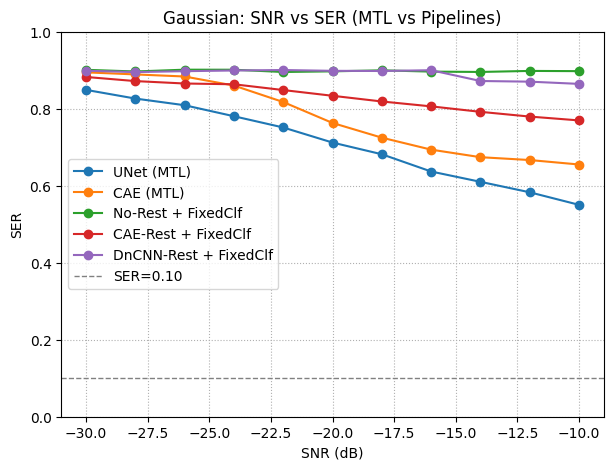

In [14]:
# Pipeline SER evaluators (no-rest and restoration+classifier)

def eval_pipeline_ser_over_snrs(classifier, restorer, x, y, snr_list_db, noise_type='gaussian', batch_size=512):
    results = {}
    for snr in snr_list_db:
        ds = make_fixed_snr_dataset_noise(x, y, snr_db=float(snr), noise_type=noise_type, batch_size=batch_size)
        total = 0; errors = 0
        for (noisy_z_b, cond_b), (clean_z_b, label_b) in ds:
            if restorer is None:
                restored = from_zscore(noisy_z_b)
            else:
                restored = restorer.predict(from_zscore(noisy_z_b), verbose=0)
            logits_b = classifier.predict(restored, verbose=0)
            pred = np.argmax(logits_b, axis=-1)
            total += label_b.shape[0]
            errors += int(np.sum(pred != label_b.numpy()))
        results[float(snr)] = errors / max(1, total)
    return results

snr_grid = list(range(-30, -9, 2))

# Evaluate pipeline baselines (Gaussian)
no_rest_ser  = eval_pipeline_ser_over_snrs(fixed_clf, None,       x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
cae_pipe_ser = eval_pipeline_ser_over_snrs(fixed_clf, cae_rest,   x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
dn_pipe_ser  = eval_pipeline_ser_over_snrs(fixed_clf, dncnn_rest, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)

# Combine plots with available MTL models (conditional add to avoid NameError)
models_map = { 'UNet (MTL)': unet_ser }
if 'cae_ser' in globals():
    models_map['CAE (MTL)'] = cae_ser
if 'dncnn_ser' in globals():
    models_map['DnCNN (MTL)'] = dncnn_ser
models_map.update({
    'No-Rest + FixedClf': no_rest_ser,
    'CAE-Rest + FixedClf': cae_pipe_ser,
    'DnCNN-Rest + FixedClf': dn_pipe_ser,
})
plot_snr_ser(models_map, title='Gaussian: SNR vs SER (MTL vs Pipelines)')



In [ ]:
# Train/Load CAE & DnCNN (MTL) on mixed noise (Gaussian/S&P/Burst)
EPOCHS_MIX = 200
cae_ckpt_mixed   = 'best_cae_multitask_mixed.keras'
dncnn_ckpt_mixed = 'best_dncnn_multitask_mixed.keras'

callbacks_cae_mixed = [
    EarlyStopping(monitor='val_classification_output_accuracy', patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath=cae_ckpt_mixed, save_weights_only=False, monitor='val_classification_output_accuracy', mode='max', save_best_only=True)
]

callbacks_dncnn_mixed = [
    EarlyStopping(monitor='val_classification_output_accuracy', patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath=dncnn_ckpt_mixed, save_weights_only=False, monitor='val_classification_output_accuracy', mode='max', save_best_only=True)
]

# Reuse compiled models (cae_model, dncnn_model) but train on mixed-noise datasets
try:
    if os.path.exists(cae_ckpt_mixed):
        print(f'Loading CAE (mixed) from {cae_ckpt_mixed}')
        cae_model_mixed = tf.keras.models.load_model(cae_ckpt_mixed)
    else:
        print('\nTraining CAE (mixed noises) ...')
        cae_model.fit(train_ds_mixed_types, epochs=EPOCHS_MIX, validation_data=val_ds_mixed_types, callbacks=callbacks_cae_mixed, verbose=1)
        cae_model.save(cae_ckpt_mixed)
        cae_model_mixed = tf.keras.models.load_model(cae_ckpt_mixed)
except Exception as e:
    print('CAE mixed training skipped due to error:', e)

try:
    if os.path.exists(dncnn_ckpt_mixed):
        print(f'Loading DnCNN (mixed) from {dncnn_ckpt_mixed}')
        dncnn_model_mixed = tf.keras.models.load_model(dncnn_ckpt_mixed)
    else:
        print('\nTraining DnCNN (mixed noises) ...')
        dncnn_model.fit(train_ds_mixed_types, epochs=EPOCHS_MIX, validation_data=val_ds_mixed_types, callbacks=callbacks_dncnn_mixed, verbose=1)
        dncnn_model.save(dncnn_ckpt_mixed)
        dncnn_model_mixed = tf.keras.models.load_model(dncnn_ckpt_mixed)
except Exception as e:
    print('DnCNN mixed training skipped due to error:', e)


In [ ]:
# Per-noise-type SER plots: Conditional UNet vs Baseline UNet
noise_types = ['gaussian', 'sp', 'burst']
per_type_maps = {}
for nt in noise_types:
    ser_cond = eval_model_ser_over_snrs(unet_model, x_test, y_test, snr_grid, noise_type=nt, batch_size=512)
    ser_base = eval_unet_base_ser_over_snrs(unet_base, x_test, y_test, snr_grid, noise_type=nt, batch_size=512)
    per_type_maps[nt] = {'UNet (MTL)': ser_cond, 'UNet (Base)': ser_base}

for nt, maps in per_type_maps.items():
    plot_snr_ser(maps, title=f'{nt.upper()}: SNR vs SER (UNet MTL vs Base)')


In [ ]:
# Per-noise-type SER plots: Pipeline baselines (FixedClf with Restorers)
pipe_maps = {}
for nt in noise_types:
    no_rest = eval_pipeline_ser_over_snrs(fixed_clf, None,       x_test, y_test, snr_grid, noise_type=nt, batch_size=512)
    cae_rest_m = eval_pipeline_ser_over_snrs(fixed_clf, cae_rest,   x_test, y_test, snr_grid, noise_type=nt, batch_size=512)
    dn_rest_m  = eval_pipeline_ser_over_snrs(fixed_clf, dncnn_rest, x_test, y_test, snr_grid, noise_type=nt, batch_size=512)
    ue_rest_m  = eval_pipeline_ser_over_snrs(fixed_clf, unet_rest,  x_test, y_test, snr_grid, noise_type=nt, batch_size=512)
    pipe_maps[nt] = {
        'No-Rest + FixedClf': no_rest,
        'CAE-Rest + FixedClf': cae_rest_m,
        'DnCNN-Rest + FixedClf': dn_rest_m,
        'UNet-Rest + FixedClf': ue_rest_m,
    }

for nt, maps in pipe_maps.items():
    plot_snr_ser(maps, title=f'{nt.upper()}: SNR vs SER (Pipelines)')



Training DnCNN (up to 200 epochs, early-stop) ...
Epoch 1/200
391/391 [==============================] - 28s 61ms/step - loss: 6.9074 - restoration_output_loss: 8.0420 - classification_output_loss: 2.3282 - classification_output_accuracy: 0.1002 - val_loss: 5.5641 - val_restoration_output_loss: 6.3699 - val_classification_output_loss: 2.3036 - val_classification_output_accuracy: 0.1031
Epoch 2/200
391/391 [==============================] - 23s 60ms/step - loss: 4.7893 - restoration_output_loss: 5.4015 - classification_output_loss: 2.3059 - classification_output_accuracy: 0.1032 - val_loss: 4.5061 - val_restoration_output_loss: 5.0486 - val_classification_output_loss: 2.3031 - val_classification_output_accuracy: 0.0990
Epoch 3/200
391/391 [==============================] - 24s 60ms/step - loss: 3.3053 - restoration_output_loss: 3.5484 - classification_output_loss: 2.3016 - classification_output_accuracy: 0.1096 - val_loss: 3.2401 - val_restoration_output_loss: 3.4665 - val_classificati

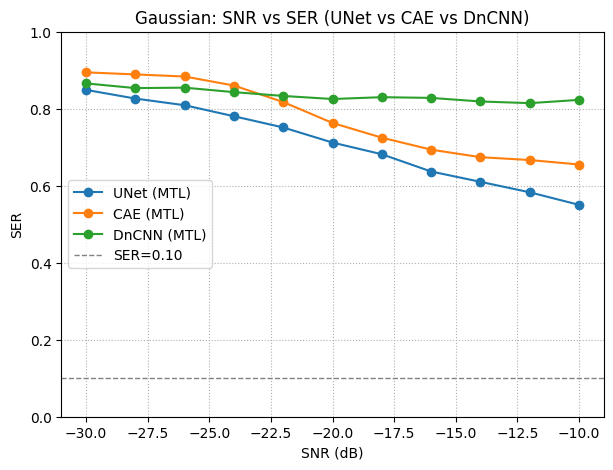

In [15]:
# Train/Load DnCNN MTL separately, then evaluate SER (Gaussian)
EPOCHS = 200
dncnn_ckpt = 'best_dncnn_multitask.keras'

callbacks_dncnn = [
    EarlyStopping(monitor='val_classification_output_accuracy', patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath=dncnn_ckpt, save_weights_only=False, monitor='val_classification_output_accuracy', mode='max', save_best_only=True)
]

if os.path.exists(dncnn_ckpt):
    print(f'Loading DnCNN weights from {dncnn_ckpt}')
    dncnn_model = tf.keras.models.load_model(dncnn_ckpt)
else:
    print('\nTraining DnCNN (up to 200 epochs, early-stop) ...')
    dncnn_model.fit(train_ds_mixed, epochs=EPOCHS, validation_data=val_ds_mixed, callbacks=callbacks_dncnn, verbose=1)

try:
    dncnn_ser = eval_model_ser_over_snrs(dncnn_model, x_test, y_test, snr_grid, noise_type='gaussian', batch_size=512)
    models_map = {'UNet (MTL)': unet_ser}
    if 'cae_ser' in globals(): models_map['CAE (MTL)'] = cae_ser
    models_map['DnCNN (MTL)'] = dncnn_ser
    plot_snr_ser(models_map, title='Gaussian: SNR vs SER (UNet vs CAE vs DnCNN)')
except Exception as e:
    print('DnCNN evaluation skipped due to error:', e)

